<div style="width: 100%; clear: both;">
  <div style="float: left; width: 50%;">
    <img src="https://brandemia.org/sites/default/files/sites/default/files/uoc_nuevo_logo.jpg" align="left" style="width: 80%;">
  </div>
  <div style="float: right; width: 50%; text-align: right;">
    <h3 style="text-align: left; font-weight: bold;">Optimización del sistema de bicicletas compartidas en la ciudad de Valencia.</h3>
    <p style="text-align: left; font-weight: bold; font-size: 100%;">Análisis predictivo, rutas de reparto para el balanceo y gestión eficiente de las estaciones.</p>
    <p style="margin: 0; text-align: right;">Jose Luis Santos Durango</p>
    <hr style="border-top: 1px solid #ccc; margin: 10px 0;">
    <p style="margin: 0; padding-top: 22px; text-align:right;">ETL_other_data.ipynb · M2.879 · Trabajo Final de Máster · Área 2</p>
    <p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de datos (Data science)</p>
    <p style="margin: 0; text-align:right;">Estudios de Informática, Multimedia y Telecomunicación</p>
  </div>
</div>
<div style="width:100%;">&nbsp;</div>

# Preparación de los datos: otras fuentes de datos

En este notebook vamos a realizar el procesamiento de los datos externos al sistema de Valenbisi con los que queremos cruzar nuestros datos de las estaciones de bicicletas. Para realizar este análisis se han tenido en cuenta distintas cuestiones comentadas con el tutor, considerando las siguientes como las más relevantes en el impacto del uso del sistema de Valenbisi:

- Cuestiones meteorológicas y atmosféricas.
- Datos geolocalizados de las estaciones.
- Zonas verdes.
- Cuestiones socioeconómicas (por barrios de la ciudad).


1. [Datos metorológicos y atomosféricos](#1)
        1.1 Extracción de los datos y transformación
        1.2 Estudio de la distribución de los valores nulos
        1.3 Conclusiones del estudio gráfico
        1.4 Almacenamiento de los datos
2. [Datos geográficos de las estaciones](#2)
        2.1 Conexión a la API del sistema
        2.2 Análisis de características
        2.3 Almacenamiento de los datos
3. [Datos económicos del precio le M2 en la ciudad](#3)
        3.1 Extracción de los datos y transformación
4. [Datos de las zonas verdes de la ciudad](#4)
        4.1 Extracción de los datos y transformación

In [1]:
# import ceil
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from shapely.geometry import Polygon, Point, MultiPolygon
import numpy as np
from pathlib import Path

In [2]:
# Get the path for desktop folder
if os.name == 'nt':  # Windows
    #desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
    weather_path = 'C:\\Users\\jose\OneDrive - E&C Consultants\\Desktop\\other_data\\weather_conditions.json'
    fotocasa_path = 'C:\\Users\\jose\OneDrive - E&C Consultants\\Desktop\\other_data\\precioM2_fotocasa.json'
    zonas_verdes_path = 'C:\\Users\\jose\OneDrive - E&C Consultants\\Desktop\\other_data\\espacios_verdes.json'
elif os.name == 'posix':  # macOS y Linux
    desktop_path = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop')
    weather_path = os.path.join(desktop_path,'other_data/weather_conditions.json')
    fotocasa_path = os.path.join(desktop_path,'other_data/precioM2_fotocasa.json')
    zonas_verdes_path = os.path.join(desktop_path,'other_data/espacios_verdes.json')
else:
    raise OSError("Non supported operative system")

# Load the JSON file into a DataFrame
with open(weather_path, 'r') as f:
    weather_data = json.load(f)
with open(fotocasa_path, 'r') as f:
    fotocasa_data = json.load(f)
with open(zonas_verdes_path, 'r') as f:
    zonas_verdes_data = json.load(f)

<a id='1'></a>
## 1. Datos meteorológicos y atmosféricos
### 1.1 Extracción de los datos y transformación

Los datos metorológicos han sido obtenidos del portal de datos abiertos del Ayuntamiento de Valencia, que permite descargar los datos en distintos formatos, así como proporciona una API para descargarlos. En este caso los hemos descargado en formato json y se han seleccionado las variables que se consideraban relevantes:
- Fecha y hora
- Velocidad del viento
- Temperatura
- Humedad relativa
- Precipitación
- Velocidad máxima del viento
- Radiación
- NO2: óxido de nitrógeno que puede ocasionar fatiga
- O3: ozono que puede ocasionar irritación de las vías respiratorias
- CO: emisiones de los vehículos que en altas concentraciones puede afectar a la visibilidad

De todas las estaciones meteorológicas que recogen los datos, se ha seleccionado la estación "Valencia centro" como la estación de referencia por su ubicación más céntrica que el resto de estaciones.

In [3]:
# Create a list to store the filtered data
filtered_data = []

# Iterate over each element in the list
for result in weather_data:
    if result['estacion'] == 'Valencia Centro':
        # Create a dictionary with the required keys
        filtered_result = {
            'fecha': result['fecha'],
            'hora': result['hora'],
            'velocidad_del_viento': result['velocidad_del_viento'],
            'temperatura': result['temperatura'],
            'humedad_relativa': result['humedad_relativa'],
            'precipitacion': result['precipitacion'],
            'velocidad_maxima_del_viento': result['velocidad_maxima_del_viento'],
            'radiacion': result['radiacion'],
            'no2': result['no2'],
            'o3': result['o3'],
            'co': result['co']
        }
        # Add the dictionary to the list
        filtered_data.append(filtered_result)

# Create a DataFrame from the list of filtered data
df_weather = pd.DataFrame(filtered_data)

# Display the resulting DataFrame
print(df_weather)


            fecha   hora  velocidad_del_viento  temperatura  humedad_relativa  \
0      2022-01-01   0:00                   NaN          NaN               NaN   
1      2022-01-01   6:00                   NaN          NaN               NaN   
2      2022-01-01   9:00                   NaN          NaN               NaN   
3      2022-01-01  13:00                   NaN          NaN               NaN   
4      2022-02-01   5:00                   NaN          NaN               NaN   
...           ...    ...                   ...          ...               ...   
17515  2022-08-31  22:00                   NaN          NaN               NaN   
17516  2022-01-09   0:00                   NaN          NaN               NaN   
17517  2022-01-09   1:00                   NaN          NaN               NaN   
17518  2022-01-09   4:00                   NaN          NaN               NaN   
17519  2022-01-09   5:00                   NaN          NaN               NaN   

       precipitacion  veloc

Podemos ver que hay una alta concentración de valores nulos, por lo que vamos a realizar un estudio de qué puede estar occuriendo. Esto puede deberse a que las mediciones de ciertos parámetros han dejado de realizarse o no se estaban realizando, o bien a mala calidad de los datos.

In [4]:
# null values 

# Count the null values in each column
null_counts = df_weather.isna().sum()

# Show the results
print("Número de valores nulos en cada columna:")
print(null_counts)

Número de valores nulos en cada columna:
fecha                              0
hora                               0
velocidad_del_viento            8888
temperatura                     8890
humedad_relativa                9765
precipitacion                   8850
velocidad_maxima_del_viento     8888
radiacion                       8884
no2                              228
o3                             17520
co                             17520
dtype: int64


### 1.2 Estudio de la distribución de los valores nulos

Para poder estudiar los valores nulos de las distintas variables que tenemos, vamos a realizar un mapa de color para ver si hay algún patrón que indique cómo se reparten estos valores nulos.

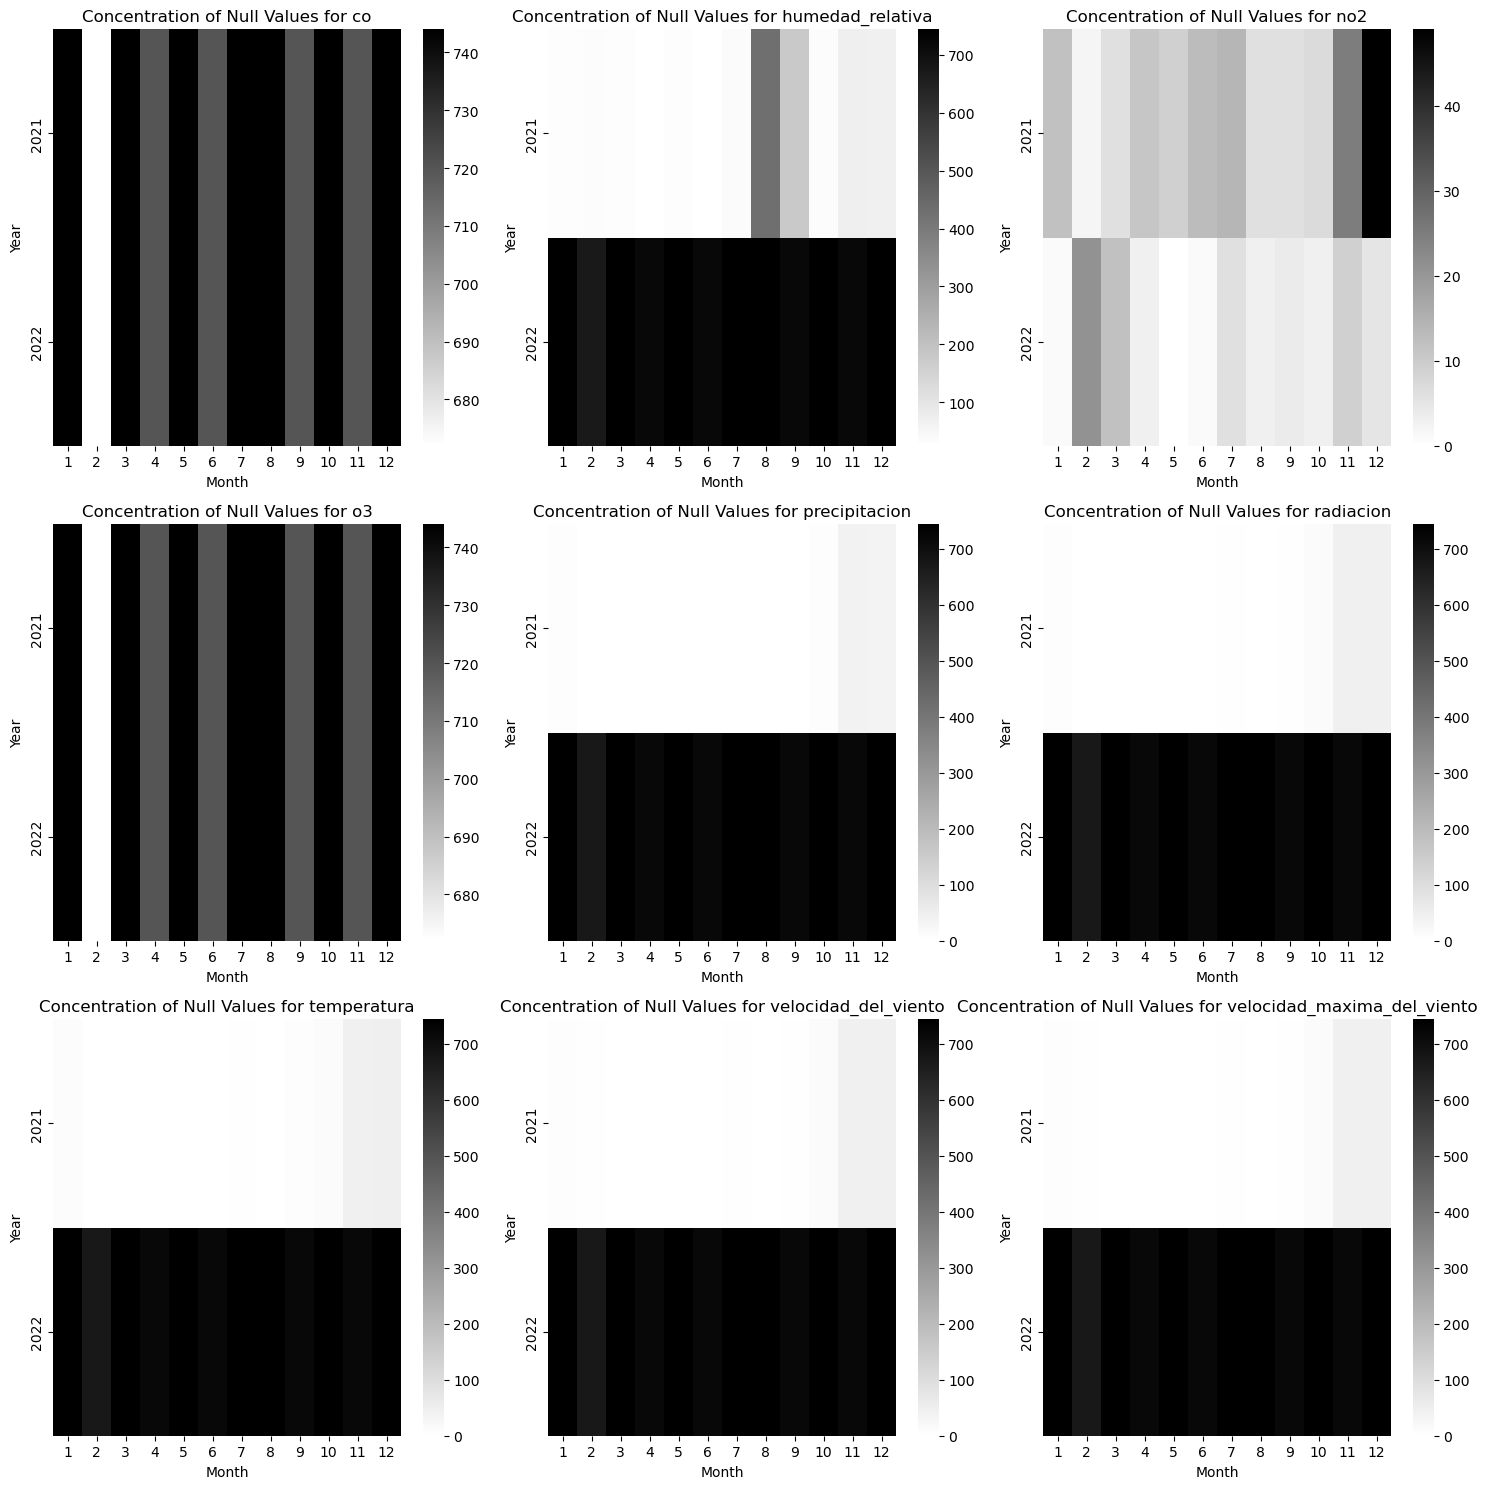

In [5]:
# Convert the date column to date type
df_weather['fecha'] = pd.to_datetime(df_weather['fecha'])

# New columns for the analysis
df_weather['mes'] = df_weather['fecha'].dt.month
df_weather['año'] = df_weather['fecha'].dt.year

# Variables that we want to add to the study
variables = df_weather.columns.difference(['fecha', 'mes', 'año', 'hora', 'year', 'month'])

# Count null values
null_counts = df_weather.groupby(['año', 'mes'])[variables].apply(lambda x: x.isnull().sum())

# Dataframe and pivot for a heatmap
pivot_null_counts = null_counts.unstack()

# Formating for subgraphs
num_variables = len(variables)
num_plots_per_row = 3
num_rows = -(-num_variables // num_plots_per_row)  # ceil division

# Create the subgraphs
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows * 5))

# Set-up subgraphs position
axes = axes.flatten()

# Iteration for different variables
for i, variable in enumerate(variables):
    ax = axes[i]
    sns.heatmap(pivot_null_counts[variable], cmap='binary', ax=ax)

    # Set-up the tittle and labels
    ax.set_title(f'Concentration of Null Values for {variable}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Year')

# Hide the non-show variables axis
for i in range(num_variables, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Parece que tenemos una alta concentración de valores nulos para el año 2022, veamos los mismos resultados en una tabla agrupada por año.

In [6]:
# Group by year and count null values for each group
null_counts = df_weather.groupby('año').apply(lambda x: x.isna().sum())

# print the results
print(null_counts)


      fecha  hora  velocidad_del_viento  temperatura  humedad_relativa  \
año                                                                      
2021      0     0                   128          130              1005   
2022      0     0                  8760         8760              8760   

      precipitacion  velocidad_maxima_del_viento  radiacion  no2    o3    co  \
año                                                                            
2021             90                          128        124  160  8760  8760   
2022           8760                         8760       8760   68  8760  8760   

      mes  año  
año             
2021    0    0  
2022    0    0  


### 1.3 Conclusiones del estudio gráfico

Como podemos ver en los gráficos de arriba, y con los datos de la tabla, para las variables meteorológicas: humedad relativa, precipitación, radiación, temperatura, valocidad del viento y velocidad máxima del viento, todos los registros horarios de 2022 son valores nulos. Esto puede deberse a la interrupción del proceso de mediciones de estos valores durante el año 2022. Para las variables atmosféricas CO y O3 podemos ver que las mediciones son dispares por meses en ambos años, y para la variable NO2, podemos ver que los datos nulos se distribuyen equitativamente en cada mes, siendo diciembre de 2021 el mes con mayor concentración de valores nulos.

Ante estos resultados, y dado el gran volumen de datos de los que disponemos de las estaciones de Valenbisi (4 años con una granularidad de minuto para 276 estaciones, suponen unos 580 millones de registros apróx.), podemos concluir que los datos con los que trabajaremos serán los correspondientes a 2021 para el histórico de las estaciones y para los datos atmosféricos.

### 1.4 Almacenamiento de los datos

In [7]:
# Filter by 2021 year 
df_weather_final = df_weather[df_weather['año'] == 2021]

# Deleting unnecesary columns
del df_weather_final['año']
del df_weather_final['mes']

# Saving the data into a txt file
df_weather_final.to_csv('weather_conditions.txt', index=False)

<a id='2'></a>
## 2. Datos geográficos de las estaciones
### 2.1 Conexión a la API del sistema

Para poder tener las estaciones geolocalizadas, podemos hacer una llamada a la API del sistema de JCDecaux, ya que las llamadas a esta API descargan datos con coordenadas geográficas de cada estación. Filtraremos solo los campos que nos interesan:
- ID de la estación
- Dirección de la estación (no relevante, solo curiosidad del autor)
- Coordenadas geográficas
- Bornetas totales de la estación

In [8]:
# URL for the API system we want to connect
url = 'https://api.jcdecaux.com/vls/v1/stations?'

# Parameters we need to connect to the API
params = {'contract': 'Valence', 'apiKey': '11fc23ba17bc01f27a7bc28ad2d8357c5080e880'}

# GET query to the API
response = requests.get(url, params=params)
data_geo = json.loads(response.text)
df_geo = pd.DataFrame(data_geo)

# Get the lat. long separated
df_geo[['lat', 'lng']] = df_geo['position'].apply(lambda x: pd.Series([x['lat'], x['lng']]))


# Seleccionar las columnas específicas y ordenar por 'number'
df_geo = df_geo.loc[:, ['number',
                        'address', 
                        'position', 
                        'bike_stands', 
                        'lat', 
                        'lng']].sort_values(by='number')

# Mostrar el DataFrame resultante
df_geo

,number,address,position,bike_stands,lat,lng
28,1,C/GUILLEM DE CASTRO esquina con C/NA JORDANA,"{'lat': 39.48001, 'lng': -0.38302}",25,39.480010,-0.383020
206,2,Salvador Giner - C. Museo,"{'lat': 39.4798571258551, 'lng': -0.3798391150...",15,39.479857,-0.379839
1,3,Plaza del Musico López Chavarri,"{'lat': 39.4768031153802, 'lng': -0.3803791150...",20,39.476803,-0.380379
163,4,Plaza de la Virgen - Bailía,"{'lat': 39.4767151166769, 'lng': -0.3754331001...",25,39.476715,-0.375433
249,5,Plaza Poeta Llorente,"{'lat': 39.4768631185303, 'lng': -0.3712310876...",15,39.476863,-0.371231
...,...,...,...,...,...,...
214,272,Vicente la Roda - Ingeniero Fausto Elio,"{'lat': 39.4805911436594, 'lng': -0.3322809729...",15,39.480591,-0.332281
75,273,Moraira - Alta del Mar,"{'lat': 39.4502730411407, 'lng': -0.3333629598...",15,39.450273,-0.333363
23,274,San Francisco de Paula - Castell de Pop,"{'lat': 39.4480380336336, 'lng': -0.3332789583...",15,39.448038,-0.333279
220,275,Moreras - Rona de Nazaret,"{'lat': 39.4522730472996, 'lng': -0.3351559662...",20,39.452273,-0.335156


### 2.2 Análisis de las características

Como podemos ver, con la API del sistema, obtenemos un total de 274 estaciones, pero sin embargo, sabemos que hay 276. Tendemos que comprobar que estaciones son las que faltan e intentar imputarlas manualmente. Para ello vamos a consultar los datos de la API de Open data del Ayuntamiento de Valencia, para extraer la información de las estaciones olvidadas.

In [9]:
sorted_numbers = sorted(df_geo['number'])
all_numbers_set = set(range(1, 277))
given_numbers_set = set(sorted_numbers)

# Missing numbers in the list
missing_numbers = sorted(list(all_numbers_set - given_numbers_set))

# Print the results
print("Las estaciones que faltan en la lista son:", missing_numbers)


Las estaciones que faltan en la lista son: [84, 101]


Accedemos a la web del Ayuntamiento de valencia y obtenemos la información de las estaciones 84 y 101 para imputarla manualmente.

In [10]:
# Station_id 84. 101
df_missed = pd.DataFrame({
    'number': [84, 101],
    'address': ['Serrería, 67', 'Marino Blas de Lezo (estación Cabañal Adif)'],
    'bike_stands': [15, 30],
    'lat': [39.46729429030231, 39.47006829907817],
    'lng': [-0.3351652508188024, -0.3343612466069016]
})

df_missed['position'] = df_missed.apply(lambda row: {'lat': row['lat'], 'lon': row['lng']}, axis=1)

# Concatenate
df_stations = pd.concat([df_missed, df_geo], ignore_index=True).sort_values(by='number')

<a id='3'></a>
## 3. Datos económicos del precio del M2 en la ciudad
### 3.1 Extracción de los datos y transformación

En este apartado vamos a extraer los datos del precio por metro cuadrado registrados en la web de Fotocasa, para los distitnos barrios de Valencia. Estos datos han sido extraídos en formato json de la página de datos abiertos del ayuntamiento. La estrategia que seguiremos será la siguiente:

- Extraer los datos en formato json con las coordenadas de los distintos barrios y su forma geométrica (delimitaciones geográficas sobre el mapa).
- Comprobar en qué forma geométrica del fichero json de Fotocasa se encuentra cada estación de Valenbisi.
- Añadir la información del barrio y del precio por metro cuadrado en el año 2022 (dato más actualizado en la página).

In [11]:
for result in fotocasa_data:
    # Get the geo data from json file
    coordinates = result['geo_shape']['geometry']['coordinates'][0]
    polygon = Polygon(coordinates)
    
    # Check the geo data from stations
    for index, row in df_stations.iterrows():
        point = Point(row['lng'], row['lat'])
        if polygon.contains(point):
            precio_2022 = result['precio_2022_euros_m2']
            barrio = result['barrio']
            distrito = result['distrito']
            
            # Add the info we need from json file to the dataframe
            df_stations.at[index, 'precio_2022_euros_m2'] = precio_2022
            df_stations.at[index, 'barrio'] = barrio
            df_stations.at[index, 'distrito'] = distrito

# Print the results
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 2 to 275
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number                276 non-null    int64  
 1   address               276 non-null    object 
 2   bike_stands           276 non-null    int64  
 3   lat                   276 non-null    float64
 4   lng                   276 non-null    float64
 5   position              276 non-null    object 
 6   precio_2022_euros_m2  272 non-null    float64
 7   barrio                276 non-null    object 
 8   distrito              276 non-null    object 
dtypes: float64(3), int64(2), object(4)
memory usage: 29.7+ KB


<a id='4'></a>
## 4. Datos de zonas verdes de la ciudad
### 4.1 Extracción de los datos y transformación

En este apartado vamos a seguir una estrategia similar a la del apartado anterior, vamos a realizar un estudio de las zonas verdes de la ciudad para saber si una estación de Valenbisi está dentro de una zona verde.

In [12]:
for result in zonas_verdes_data:
    # Get the geo data from json file
    if result.get('geo_shape') is not None:
        geometry_type = result['geo_shape']['geometry']['type']
        if geometry_type == 'Polygon':
            coordinates = result['geo_shape']['geometry']['coordinates'][0]
            polygon = Polygon(coordinates)
        elif geometry_type == 'MultiPolygon':
            coordinates = result['geo_shape']['geometry']['coordinates']
            polygons = [Polygon(coords[0]) for coords in coordinates]
            multipolygon = MultiPolygon(polygons)
    
        # Check the geo data from stations
        count = 0
        for index, row in df_stations.iterrows():
            point = Point(row['lng'], row['lat'])
            if geometry_type == 'Polygon' and polygon.contains(point):
                inside_green_area = True
                green_area_shape = polygon
                count+=1
            elif geometry_type == 'MultiPolygon' and multipolygon.contains(point):
                inside_green_area = True
                green_area_shape = multipolygon
                count+=1
            else:
                inside_green_area = False
                green_area_shape = None
                
# Print the total count of stations inside green areas
print("Total stations inside green areas:", count)

Total stations inside green areas: 0


Podemos ver que ninguna de las estaciones se localiza dentro de un área verde, luego es un dato que no es relevante para el estudio. Para enfocarlo de otra manera, lo que haremos será estudiar cuál es el área verde más cercana a la estación de Valenbisi, y añadiremos los metros cuadrados que tiene el área verde. Consideramos que es un campo interesante a analizar ya que es probable que las estaciones cercanas a los jardines del Turia tengan menor disponibilidad de bicicletas debido a un aumento de demanda los meses de primavera y verano. Por el contrario, las zonas alejadas de grandes zonas verdes puede que tengan una menor disponibilidad de bornetas libres al disminuir el uso del sistema en el área.

In [13]:
# Function to calculate the distance between two points
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Iterate over the records in the DataFrame
for index, row in df_stations.iterrows():
    # Coordinates of the DataFrame record
    station_point = (row['lng'], row['lat'])
    
    # Initialize the minimum distance as infinity
    min_distance = np.inf
    closest_shape = None
    
    # Iterate over the records in the JSON file
    for feature in zonas_verdes_data:
        if feature['geo_point_2d'] is not None:
            # Coordinates from the JSON file
            json_point = (feature['geo_point_2d']['lon'], feature['geo_point_2d']['lat'])

            # Calculate the distance between the DataFrame coordinates and the JSON coordinates
            dist = distance(station_point, json_point)

            # Update the minimum distance and the closest polygon
            if dist < min_distance:
                min_distance = dist
                closest_shape = feature

        # Add the information from the "st_area_shape" field to the DataFrame
        df_stations.at[index, 'close_green_area_shape'] = closest_shape['st_area_shape']
        df_stations.at[index, 'close_green_area_name'] = closest_shape['nombre']

# Printing the results
df_stations.head()

,number,address,bike_stands,lat,lng,position,precio_2022_euros_m2,barrio,distrito,close_green_area_shape,close_green_area_name
2,1,C/GUILLEM DE CASTRO esquina con C/NA JORDANA,25,39.480010,-0.383020,"{'lat': 39.48001, 'lng': -0.38302}",2577.0,EL CARME,CIUTAT VELLA,2019.382380,TRASERA IVAM - PATI OBERT IVAM
3,2,Salvador Giner - C. Museo,15,39.479857,-0.379839,"{'lat': 39.4798571258551, 'lng': -0.3798391150...",2577.0,EL CARME,CIUTAT VELLA,910.344686,JESUS MAROTO Y GONZALEZ PL
4,3,Plaza del Musico López Chavarri,20,39.476803,-0.380379,"{'lat': 39.4768031153802, 'lng': -0.3803791150...",2577.0,EL CARME,CIUTAT VELLA,210.374823,MUSICO LOPEZ CHAVARRI PL
5,4,Plaza de la Virgen - Bailía,25,39.476715,-0.375433,"{'lat': 39.4767151166769, 'lng': -0.3754331001...",3545.0,LA SEU,CIUTAT VELLA,761.710491,CABALLEROS C - LA VIRGEN PL (PALAU DE LA GENER...
6,5,Plaza Poeta Llorente,15,39.476863,-0.371231,"{'lat': 39.4768631185303, 'lng': -0.3712310876...",3393.0,LA XEREA,CIUTAT VELLA,63100.999461,JARDIN DEL TURIA (TRAMO 8)


In [14]:
# Saving the data into a txt file
df_stations.to_csv('stations.txt', index=False)